# Housing Analysis for Seattle-based Real-Estate Company

Overview:<br>

A company owns a number of real-estate home properties in Seattle and has hired us to provide renovation recommendations on how to increase the prices of these properties.

Business Problem: <br>

What kind of rennovations should we recommend?

Analysis Focus:
1. Our analysis will focus on houses in Seattle. 
2. Explore what variables are correlated to the housing prices.
3. Advise and provide recommendations on rennovation goals to enrich Real-Estate Company's book of business.

### Install uszipcode to translate zip codes into cities

In [1]:
pip install uszipcode

### Importing libraries and data into DataFrames

In [2]:
#Import neccessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import requests
import statsmodels.api as sm
import statsmodels.stats.api as sms
import scipy.stats as stats
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate

In [3]:
#Load in dataset
df = pd.read_csv('data/kc_house_data.csv')

In [4]:
#Previewing dataframe
display(df.shape)
df.head()

(21597, 21)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


### Data Cleaning

###### Initial thoughts

1. Let's pull the month for each records of `date`.
2. What variables don't make sense to model in our linear regression analysis? Let's drop these fields and narrow our dataframe.
3. Let's convert zip code to city to see the geographical distribution of our data.

In [5]:
#Definining a function to pull the month in each date field
def make_month(string):
    if string[:2] == '1/':
        return 'Jan'
    if string[:2] == '2/':
        return 'Feb'
    if string[:2] == '3/':
        return 'Mar'
    if string[:2] == '4/':
        return 'Apr'
    if string[:2] == '5/':
        return 'May'
    if string[:2] == '6/':
        return 'Jun'
    if string[:2] == '7/':
        return 'Jul'
    if string[:2] == '8/':
        return 'Aug'
    if string[:2] == '9/':
        return 'Sep'
    if string[:2] == '10':
        return 'Oct'
    if string[:2] == '11':
        return 'Nov'
    if string[:2] == '12':
        return 'Dec'
    
#Checks for houses with the SAME latitude and longitude and keeps only the house with the latest
#year while deleting the records for the others (the house with the most recent year is the most
#relevant)
lat_long = {}
for a, b in zip(df['lat'].values, df['long'].values):
    if (a, b) not in list(lat_long.keys()):
        lat_long[(a, b)] = 1
    else:
        lat_long[(a, b)] += 1
for item in list(lat_long.keys()):
    if lat_long[item] < 2:
        del lat_long[item]
for item in list(lat_long.keys()):
        dfx = df[(df.lat == item[0]) & (df.long == item[1])]
        for id_d in dfx['id'].values:
            if dfx.loc[dfx['id'] == id_d]['yr_built'].values[0] != max(dfx['yr_built'].values):
                df = df.drop([df.loc[df['id'] == id_d].index[0]])

#Drops irrelevent fields
df_alt = df.drop(['id', 'date', 'yr_built', 'yr_renovated', 'view'], axis = 1)

month_list = []
sqft_basement_list = []
yr_renovated = []

#Create new column to represent month house was sold
for date in df['date'].values:
    month_list.append(make_month(date))
    
#Clean up data in sqft_basement (convert string into float)
for num in df['sqft_basement'].values:
    if num == '?':
        sqft_basement_list.append(np.nan)
    else:
        sqft_basement_list.append(float(num))

#Convert year-renovated to a boolean to indicate whether a house was renovated or not
for data in df['yr_renovated'].values:
    if data == 0:
        yr_renovated.append(0)
    elif data == np.nan:
        yr_renovated.append(np.nan)
    else:
        yr_renovated.append(1)

#Appending new  data into new dataframe
df_alt['month'] = month_list
df_alt['sqft_basement'] = sqft_basement_list
df_alt['renovated'] = yr_renovated

#Calculates age of house
df_alt['age_of_house'] = 2021 - df['yr_built']

df_alt.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,month,renovated,age_of_house
0,221900.0,3,1.00,1180,5650,1.0,NaN,3,7,1180,0.0,98178,47.5112,-122.257,1340,5650,Oct,0,66
1,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,2170,400.0,98125,47.7210,-122.319,1690,7639,Dec,1,70
2,180000.0,2,1.00,770,10000,1.0,0.0,3,6,770,0.0,98028,47.7379,-122.233,2720,8062,Feb,1,88
3,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,1050,910.0,98136,47.5208,-122.393,1360,5000,Dec,0,56
4,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,1680,0.0,98074,47.6168,-122.045,1800,7503,Feb,0,34


In [6]:
#Converting zipcode to city
from uszipcode import SearchEngine, SimpleZipcode, Zipcode
search = SearchEngine()

def zip_lookup(x):
    city = search.by_zipcode(x).major_city
    return city if city else 'None'

df_alt['City'] = df_alt['zipcode'].apply(zip_lookup)

In [7]:
#Previewing the geography of our data
df_alt['City'].value_counts()

Seattle          8792
Renton           1581
Bellevue         1396
Kent             1192
Kirkland          968
Redmond           967
Auburn            908
Sammamish         794
Federal Way       773
Issaquah          724
Maple Valley      582
Woodinville       470
Snoqualmie        307
Kenmore           280
Mercer Island     279
Enumclaw          231
North Bend        217
Bothell           195
Duvall            189
Carnation         122
Vashon            117
Black Diamond      99
Fall City          80
Medina             49
Name: City, dtype: int64

###### Findings

With most of the housing data based in Seattle, we decided to subset our data to only include houses in Seattle.

In [8]:
df_seattle = df_alt[df_alt['City'] == 'Seattle']
df_seattle

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,month,renovated,age_of_house,City
0,221900.0,3,1.00,1180,5650,1.0,NaN,3,7,1180,0.0,98178,47.5112,-122.257,1340,5650,Oct,0,66,Seattle
1,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,2170,400.0,98125,47.7210,-122.319,1690,7639,Dec,1,70,Seattle
3,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,1050,910.0,98136,47.5208,-122.393,1360,5000,Dec,0,56,Seattle
7,291850.0,3,1.50,1060,9711,1.0,0.0,3,7,1060,0.0,98198,47.4095,-122.315,1650,9711,Jan,0,58,Seattle
8,229500.0,3,1.00,1780,7470,1.0,0.0,3,7,1050,730.0,98146,47.5123,-122.337,1780,8113,Apr,0,61,Seattle
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21591,475000.0,3,2.50,1310,1294,2.0,0.0,3,8,1180,130.0,98116,47.5773,-122.409,1330,1265,Feb,0,13,Seattle
21592,360000.0,3,2.50,1530,1131,3.0,0.0,3,8,1530,0.0,98103,47.6993,-122.346,1530,1509,May,0,12,Seattle
21593,400000.0,4,2.50,2310,5813,2.0,0.0,3,8,2310,0.0,98146,47.5107,-122.362,1830,7200,Feb,0,7,Seattle
21594,402101.0,2,0.75,1020,1350,2.0,0.0,3,7,1020,0.0,98144,47.5944,-122.299,1020,2007,Jun,0,12,Seattle


# Linear Regression

Now that we have subsetted our data, let's take a look at generating a multiple linear regression.

In [9]:
#Separating our categorical and continuous variables
categorical = ['waterfront', 'grade', 'condition', 'month', 'renovated']
continuous = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'sqft_living15', 'sqft_lot15', 'age_of_house']

Let's look at the continuous variables for our regression first:

In [10]:
#stats-model method

#creating variables to predict target
df_preds_continuous = df_seattle[continuous]
df_target = df_seattle['price']

#scale variables
df_preds_scaled = (df_preds_continuous - np.mean(df_preds_continuous)) / np.std(df_preds_continuous)

#add constant
predictors = sm.add_constant(df_preds_scaled)

model = sm.OLS(df_target, predictors).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.635
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     1913.
Date:                Thu, 22 Apr 2021   Prob (F-statistic):               0.00
Time:                        09:51:30   Log-Likelihood:            -1.2006e+05
No. Observations:                8792   AIC:                         2.401e+05
Df Residuals:                    8783   BIC:                         2.402e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.356e+05   2200.596    243.383      0.000    5.31e+05     5.4e+05
bedrooms      -5.588e+04   2773.090    -20.151      0.000   -6.13e+04   -5.04e+04
bathrooms      2.342e+04   3735.474      6.270      0.000    1.61e+04    3.07e+04
sqft_living    1.997e+05   4116.764     48.503      0.000    1.92e+05    2.08e+05
sqft_lot      -5332.1486   3194.289     -1.669      0.095   -1.16e+04     929.405
floors          5.83e+04   2852.872     20.435      0.000    5.27e+04    6.39e+04
sqft_living15  9.765e+04   2975.857     32.813      0.000    9.18e+04    1.03e+05
sqft_lot15    -2.999e+04   3238.335     -9.260      0.000   -3.63e+04   -2.36e+04
age_of_house   7.345e+04   2697.278     27.230      0.000    6.82e+04    7.87e+04
==============================================================================
Omnibus:                     5802.755   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           314748.739
Skew:                           2.516   Prob(JB):                         0.00
Kurtosis:                      31.877   Cond. No.                         3.91
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Our model has an adjusted r-squared value of .635, meaning that our continuous variables account for 63.5% of the variation in price. 

What about multicollinearity? How correlated are our continuous variables?

In [11]:
df_seattle[continuous].corr()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_living15,sqft_lot15,age_of_house
bedrooms,1.000000,0.483699,0.583334,0.145208,0.117590,0.316147,0.118922,-0.018321
bathrooms,0.483699,1.000000,0.696931,0.024176,0.479319,0.415430,0.009177,-0.396629
sqft_living,0.583334,0.696931,1.000000,0.276765,0.240371,0.646630,0.250288,-0.083202
sqft_lot,0.145208,0.024176,0.276765,1.000000,-0.254903,0.288969,0.709598,0.112836
floors,0.117590,0.479319,0.240371,-0.254903,1.000000,0.084850,-0.283576,-0.478013
sqft_living15,0.316147,0.415430,0.646630,0.288969,0.084850,1.000000,0.313297,0.027495
sqft_lot15,0.118922,0.009177,0.250288,0.709598,-0.283576,0.313297,1.000000,0.086727
age_of_house,-0.018321,-0.396629,-0.083202,0.112836,-0.478013,0.027495,0.086727,1.000000


Let's isolate the variables with "high correlation" (defined as greater than .6).

In [12]:
#let's isolate the variables with "high correlation"
df_corr = df_seattle[continuous].corr().abs().stack().reset_index().sort_values(0, ascending=False)

df_corr['pairs'] = list(zip(df_corr.level_0, df_corr.level_1))

df_corr.set_index(['pairs'], inplace = True)

df_corr.drop(columns=['level_1', 'level_0'], inplace = True)

# cc for correlation coefficient
df_corr.columns = ['cc']

df_corr.drop_duplicates(inplace=True)

df_corr[(df_corr.cc>.60) & (df_corr.cc<1)]

,cc
pairs,
"(sqft_lot15, sqft_lot)",0.709598
"(sqft_living, bathrooms)",0.696931
"(sqft_living, sqft_living15)",0.646630


#### Interpretation

Drop `sqft_living15` and `bathrooms` b/c of correlation with sqft_living. <br>
Drop `sqft_lot` because high prob (.091), meaning there isn't a statistically significant correlation between price and footage of the lot.

Based on this, let's re-declare our continuous variables. 

In [13]:
continuous = ['bedrooms', 'sqft_living', 'floors', 'sqft_lot15', 'age_of_house']

#creating variables to predict target
df_preds_continuous = df_seattle[continuous]
df_target = df_seattle['price']

#scale variables
df_preds_scaled = (df_preds_continuous - np.mean(df_preds_continuous)) / np.std(df_preds_continuous)

#add constant
predictors = sm.add_constant(df_preds_scaled)

model = sm.OLS(df_target, predictors).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.588
Method:                 Least Squares   F-statistic:                     2509.
Date:                Thu, 22 Apr 2021   Prob (F-statistic):               0.00
Time:                        09:51:30   Log-Likelihood:            -1.2060e+05
No. Observations:                8792   AIC:                         2.412e+05
Df Residuals:                    8786   BIC:                         2.412e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         5.356e+05   2338.449    229.036      0.000    5.31e+05     5.4e+05
bedrooms     -6.147e+04   2884.380    -21.313      0.000   -6.71e+04   -5.58e+04
sqft_living    2.77e+05   3101.272     89.310      0.000    2.71e+05    2.83e+05
floors        6.473e+04   2929.904     22.093      0.000     5.9e+04    7.05e+04
sqft_lot15   -1.994e+04   2605.339     -7.652      0.000    -2.5e+04   -1.48e+04
age_of_house  7.477e+04   2672.467     27.978      0.000    6.95e+04       8e+04
==============================================================================
Omnibus:                     4957.281   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           150956.290
Skew:                           2.148   Prob(JB):                         0.00
Kurtosis:                      22.840   Cond. No.                         2.30
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Does our model satisfy the assumptions for linear regression?

Assumptions for linear regression
1. The relationship between the target and predictor is linear <br>
2. The errors are independent<br>
3. The errors are normally distributed<br>
4. The errors are homoskedastic (errors have the same variance)

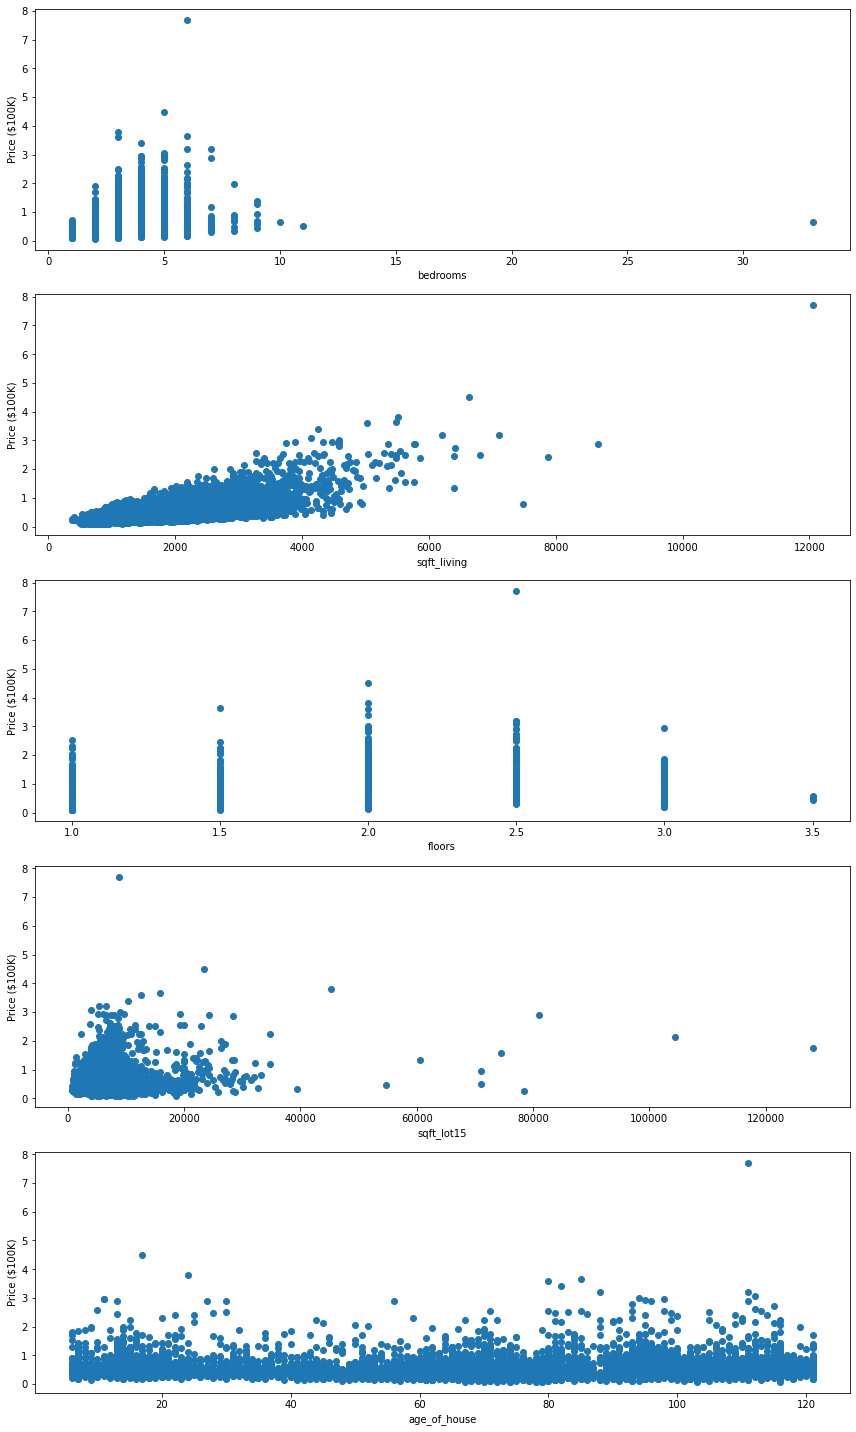

In [14]:
#1. The relationship between the target and predictor is linear - FALSE
fig, ax = plt.subplots(len(continuous), figsize=(12, 20)) 

for x in range(0,len(continuous)):
    ax[x].scatter(y=df_seattle['price']/1000000, x=df_seattle[continuous[x]])
    ax[x].set_xlabel(continuous[x])
    ax[x].set_ylabel('Price ($100K)')
    
plt.tight_layout()

In [15]:
#2. The errors are independent - TRUE

#The Durbin Watson (DW) statistic is a test for autocorrelation in the residuals from a statistical regression analysis. 
#The Durbin-Watson statistic will always have a value between 0 and 4. 
#A value of 2.0 means that there is no autocorrelation detected in the sample. 
#Values from 0 to less than 2 indicate positive autocorrelation and values from from 2 to 4 indicate negative autocorrelation.

#source: https://www.investopedia.com/terms/d/durbin-watson-statistic.asp#:~:text=The%20Durbin%2DWatson%20statistic%20will,to%204%20indicate%20negative%20autocorrelation.

# The DW statistic is 1.971, indicating there is minimal autocorrelation. 

<ipython-input-16-22bd4f592d58>:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


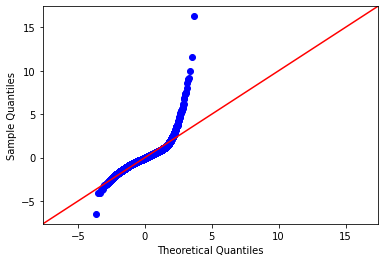

In [16]:
#3. The errors are normally distributed - FALSE

#JB score is much larger than 6, indicating errors are not normally distributed

#Confirm this with QQ plot
residuals = model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

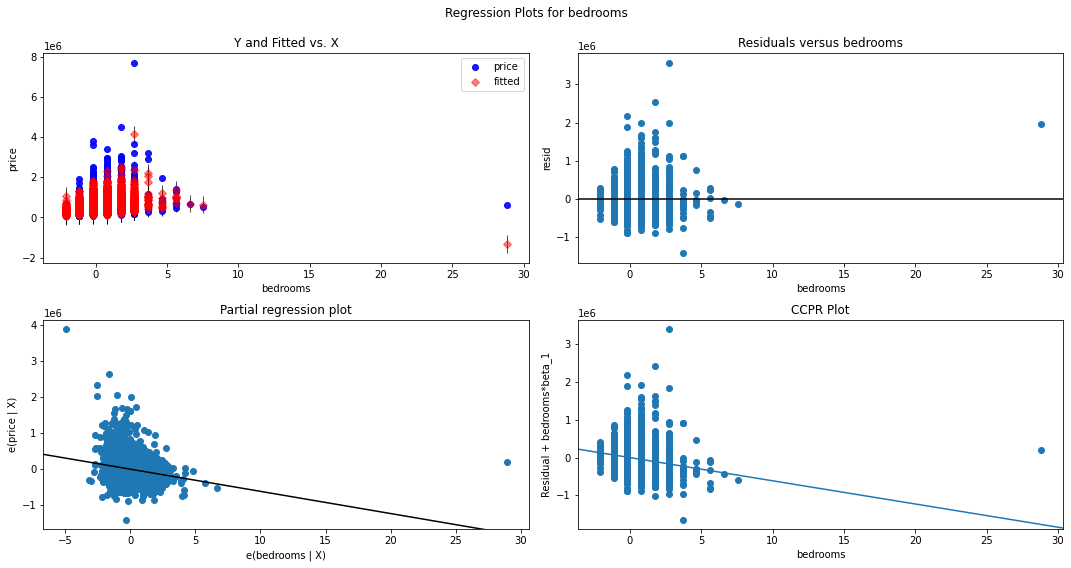

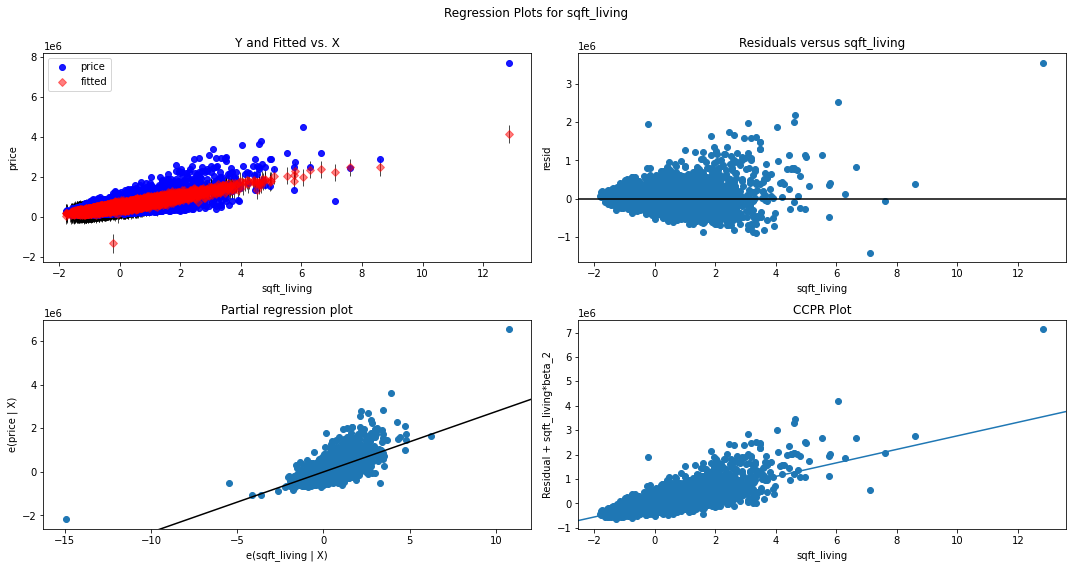

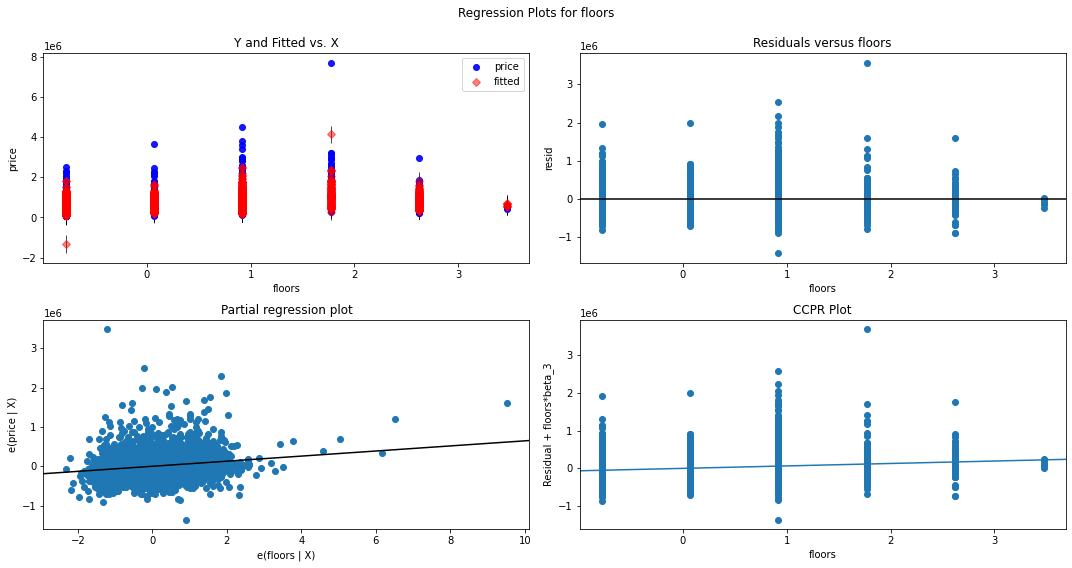

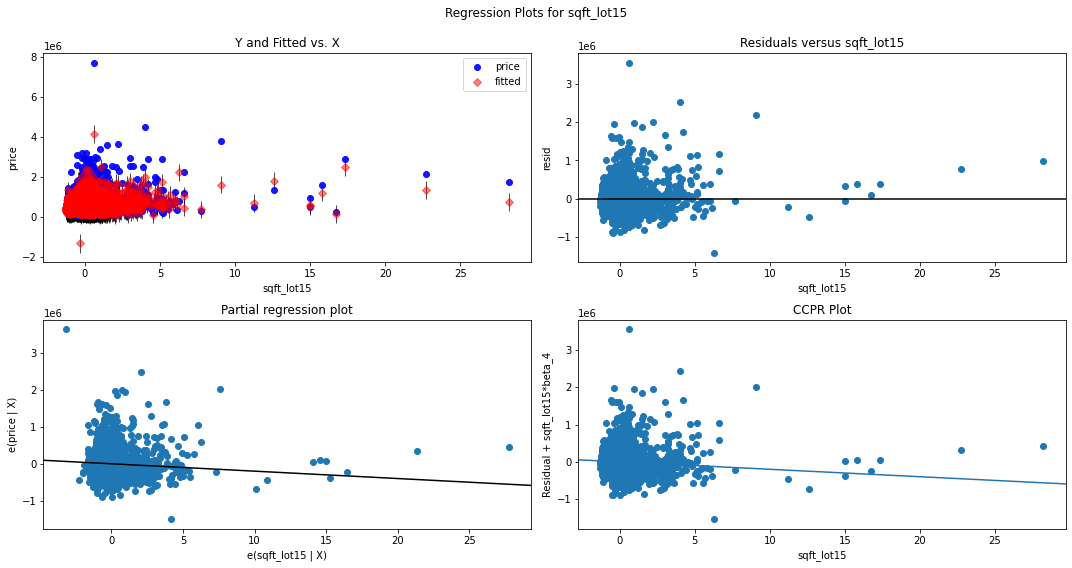

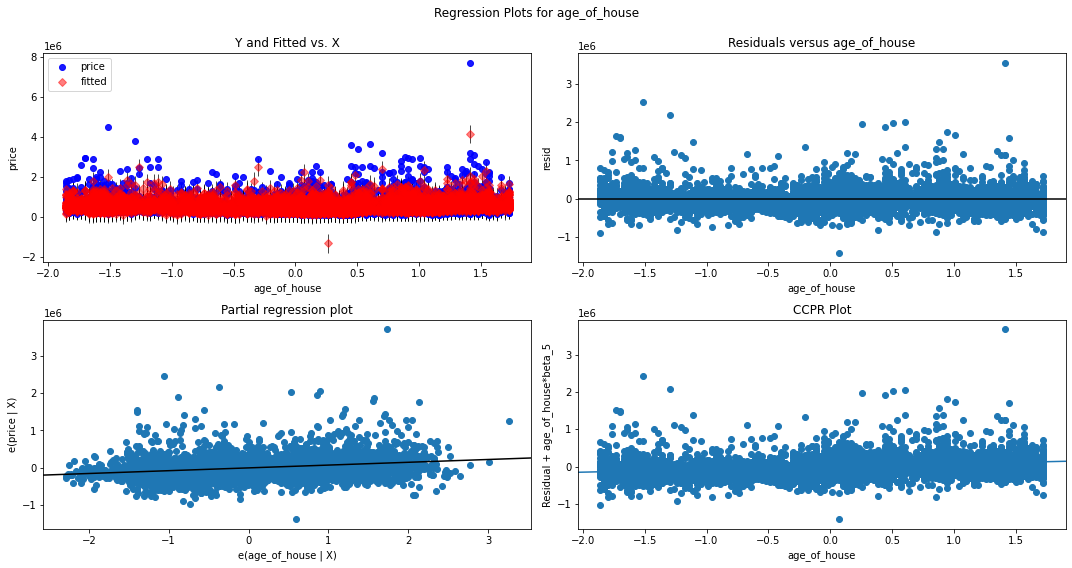

In [17]:
#4. The errors are homoskedastic (errors have the same variance) - FALSE. Residuals seem to have pattern/cone-shape.

for x in range(0,len(continuous)):
    fig = plt.figure(figsize=(15,8))
    fig = sm.graphics.plot_regress_exog(model, continuous[x], fig=fig)
    plt.show()

Our model violates most of assumptions required for linear regression. Let's look at the distribution of our continuous variables and exclude outliers and see if this helps. 

3     3895
4     2083
2     1969
5      544
1      133
6      131
7       21
8        7
9        6
11       1
10       1
33       1
Name: bedrooms, dtype: int64

count    8792.000000
mean        3.173908
std         1.034778
min         1.000000
25%         3.000000
50%         3.000000
75%         4.000000
max        33.000000
Name: bedrooms, dtype: float64

(array([8.08e+03, 6.96e+02, 1.40e+01, 1.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 1.00e+00]),
 array([ 1. ,  4.2,  7.4, 10.6, 13.8, 17. , 20.2, 23.4, 26.6, 29.8, 33. ]),
 <BarContainer object of 10 artists>)

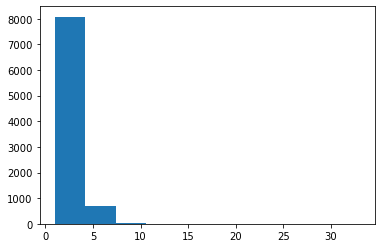

In [18]:
#Exploring the bedrooms variable
display(df_seattle.bedrooms.value_counts(), df_seattle.bedrooms.describe())
plt.hist(df_seattle.bedrooms)

#Limit bedrooms to 2 - 5?

count     8792.000000
mean      1799.666515
std        798.118612
min        370.000000
25%       1240.000000
50%       1640.000000
75%       2190.000000
max      12050.000000
Name: sqft_living, dtype: float64

(array([3.859e+03, 3.871e+03, 8.870e+02, 1.410e+02, 2.300e+01, 7.000e+00,
        2.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([  370.,  1538.,  2706.,  3874.,  5042.,  6210.,  7378.,  8546.,
         9714., 10882., 12050.]),
 <BarContainer object of 10 artists>)

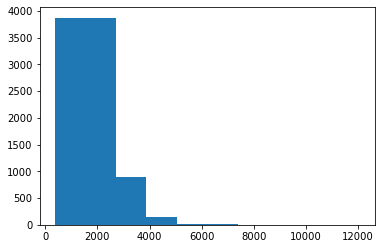

In [19]:
#Exploring the sqft_living variable
display(df_seattle.sqft_living.describe())
plt.hist(df_seattle.sqft_living)

#Limit to less than 3,000 sq ft?

count      8792.000000
mean       6208.089286
std        4318.311745
min         651.000000
25%        4000.000000
50%        5625.000000
75%        7752.000000
max      128066.000000
Name: sqft_lot15, dtype: float64

(array([8.511e+03, 2.390e+02, 3.100e+01, 2.000e+00, 2.000e+00, 3.000e+00,
        2.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([   651. ,  13392.5,  26134. ,  38875.5,  51617. ,  64358.5,
         77100. ,  89841.5, 102583. , 115324.5, 128066. ]),
 <BarContainer object of 10 artists>)

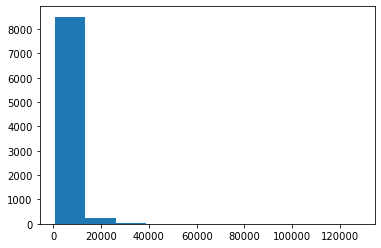

In [20]:
#Exploring the sqft_lot15 variable
display(df_seattle.sqft_lot15.describe())
plt.hist(df_seattle.sqft_lot15)

>Above: Let's drop the `sqft_lot15`. The square footage of the land lots of the nearest 15 neighbors doesn't seem to be something that most would consider to drive up the price of a house.


1.0    4670
2.0    2109
1.5    1362
3.0     547
2.5      98
3.5       6
Name: floors, dtype: int64

count    8792.000000
mean        1.460191
std         0.587432
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         3.500000
Name: floors, dtype: float64

(array([4670.,    0., 1362.,    0., 2109.,    0.,   98.,    0.,  547.,
           6.]),
 array([1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 , 2.75, 3.  , 3.25, 3.5 ]),
 <BarContainer object of 10 artists>)

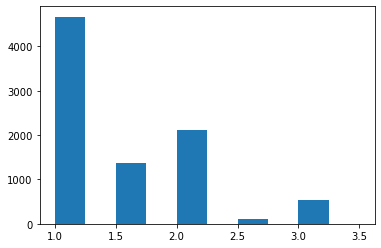

In [21]:
#Exploring the floors variable
display(df_seattle.floors.value_counts(), df_seattle.floors.describe())
plt.hist(df_seattle.floors)

#Limit to houses with either 1 or 2 floors?
#is there a statistically significant difference in prices between houses with either 1 or 2 floors?

>Above: Is there a statistically significant difference in price between houses with either 1 or 2 floors?

Based on our data findings, let's create a new dataframe that doesn't contain outliers. This includes houses that are: <br>
-5 bedrooms or less<br>
-`sqft_living` of 3000 or less<br>
-Either 1 or 2 floors

In [22]:
df_seattle_no_outliers = df_seattle[(df_seattle.bedrooms <= 5) & (df_seattle.bedrooms >=2) & (df_seattle.sqft_living <= 3000) & 
                            ((df_seattle.floors == 1) | (df_seattle.floors ==2))]

df_seattle_no_outliers

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,month,renovated,age_of_house,City
0,221900.0,3,1.00,1180,5650,1.0,NaN,3,7,1180,0.0,98178,47.5112,-122.257,1340,5650,Oct,0,66,Seattle
1,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,2170,400.0,98125,47.7210,-122.319,1690,7639,Dec,1,70,Seattle
3,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,1050,910.0,98136,47.5208,-122.393,1360,5000,Dec,0,56,Seattle
7,291850.0,3,1.50,1060,9711,1.0,0.0,3,7,1060,0.0,98198,47.4095,-122.315,1650,9711,Jan,0,58,Seattle
8,229500.0,3,1.00,1780,7470,1.0,0.0,3,7,1050,730.0,98146,47.5123,-122.337,1780,8113,Apr,0,61,Seattle
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21575,572000.0,4,2.75,2770,3852,2.0,0.0,3,8,2770,0.0,98178,47.5001,-122.232,1810,5641,Oct,1,7,Seattle
21591,475000.0,3,2.50,1310,1294,2.0,0.0,3,8,1180,130.0,98116,47.5773,-122.409,1330,1265,Feb,0,13,Seattle
21593,400000.0,4,2.50,2310,5813,2.0,0.0,3,8,2310,0.0,98146,47.5107,-122.362,1830,7200,Feb,0,7,Seattle
21594,402101.0,2,0.75,1020,1350,2.0,0.0,3,7,1020,0.0,98144,47.5944,-122.299,1020,2007,Jun,0,12,Seattle


What about outliers in price?

count    6.062000e+03
mean     4.623929e+05
std      2.174564e+05
min      7.800000e+04
25%      3.154562e+05
50%      4.200000e+05
75%      5.600000e+05
max      2.000000e+06
Name: price, dtype: float64

(array([ 978., 2658., 1513.,  565.,  214.,   72.,   40.,   13.,    6.,
           3.]),
 array([  78000.,  270200.,  462400.,  654600.,  846800., 1039000.,
        1231200., 1423400., 1615600., 1807800., 2000000.]),
 <BarContainer object of 10 artists>)

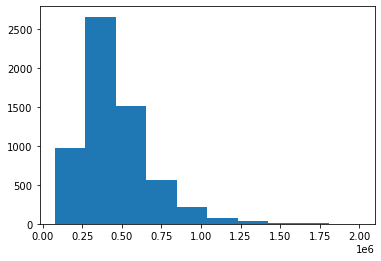

In [23]:
#Exploring outliers in price
display(df_seattle_no_outliers.price.describe())
plt.hist(df_seattle_no_outliers.price)

Let's further subset our data to only capture housing prices that are within 1 standard deviation from the mean.

In [24]:
#convert price to be in $M
df_seattle_no_outliers['price_adjusted_M'] = df_seattle_no_outliers['price'] / 1000000
df_seattle_no_outliers

std = df_seattle_no_outliers['price_adjusted_M'].std()
mean = df_seattle_no_outliers['price_adjusted_M'].mean()

#let's subset our data further by looking at housing prices within 1 standard deviation1 from the mean
lower_bound = mean - std
upper_bound = mean + std

df_seattle_no_outliers = df_seattle_no_outliers[(df_seattle_no_outliers['price_adjusted_M'] >= lower_bound) & 
        (df_seattle_no_outliers['price_adjusted_M'] <= upper_bound)]
df_seattle_no_outliers

<ipython-input-24-688d7206a42b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_seattle_no_outliers['price_adjusted_M'] = df_seattle_no_outliers['price'] / 1000000


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,...,zipcode,lat,long,sqft_living15,sqft_lot15,month,renovated,age_of_house,City,price_adjusted_M
1,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,2170,...,98125,47.7210,-122.319,1690,7639,Dec,1,70,Seattle,0.538000
3,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,1050,...,98136,47.5208,-122.393,1360,5000,Dec,0,56,Seattle,0.604000
7,291850.0,3,1.50,1060,9711,1.0,0.0,3,7,1060,...,98198,47.4095,-122.315,1650,9711,Jan,0,58,Seattle,0.291850
11,468000.0,2,1.00,1160,6000,1.0,0.0,4,7,860,...,98115,47.6900,-122.292,1330,6000,May,0,79,Seattle,0.468000
15,650000.0,4,3.00,2950,5000,2.0,0.0,3,9,1980,...,98126,47.5714,-122.375,2140,4000,Jan,0,42,Seattle,0.650000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21575,572000.0,4,2.75,2770,3852,2.0,0.0,3,8,2770,...,98178,47.5001,-122.232,1810,5641,Oct,1,7,Seattle,0.572000
21591,475000.0,3,2.50,1310,1294,2.0,0.0,3,8,1180,...,98116,47.5773,-122.409,1330,1265,Feb,0,13,Seattle,0.475000
21593,400000.0,4,2.50,2310,5813,2.0,0.0,3,8,2310,...,98146,47.5107,-122.362,1830,7200,Feb,0,7,Seattle,0.400000
21594,402101.0,2,0.75,1020,1350,2.0,0.0,3,7,1020,...,98144,47.5944,-122.299,1020,2007,Jun,0,12,Seattle,0.402101


#### Summary of Final Dataset
-Houses in Seattle<br>
-5 bedrooms or less<br>
-`sqft_living` of 3000 or less<br>
-Either 1 or 2 floors <br>
-Price between 104,000 - 762,000

In [25]:
continuous = ['bedrooms', 'sqft_living', 'floors', 'age_of_house']

df_preds_continuous = df_seattle_no_outliers[continuous]
df_target = df_seattle_no_outliers['price']

#scale variables
df_preds_scaled = (df_preds_continuous - np.mean(df_preds_continuous)) / np.std(df_preds_continuous)

#add constant
predictors = sm.add_constant(df_preds_scaled)

model = sm.OLS(df_target, predictors).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.181
Method:                 Least Squares   F-statistic:                     255.9
Date:                Thu, 22 Apr 2021   Prob (F-statistic):          8.20e-199
Time:                        09:51:39   Log-Likelihood:                -59574.
No. Observations:                4601   AIC:                         1.192e+05
Df Residuals:                    4596   BIC:                         1.192e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         4.265e+05   1499.186    284.510      0.000    4.24e+05    4.29e+05
bedrooms     -1.692e+04   1969.977     -8.589      0.000   -2.08e+04   -1.31e+04
sqft_living   5.205e+04   1984.022     26.235      0.000    4.82e+04    5.59e+04
floors        2.429e+04   1876.176     12.947      0.000    2.06e+04     2.8e+04
age_of_house  3.065e+04   1902.331     16.113      0.000    2.69e+04    3.44e+04
==============================================================================
Omnibus:                      122.295   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               90.280
Skew:                           0.246   Prob(JB):                     2.49e-20
Kurtosis:                       2.522   Cond. No.                         2.36
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Removing outliers hasn't improved our model. This leads us to believe that we are modeling too many variables... 

Often times, simpler models are better. Let's consider the r-squared values of individual variables.

In [26]:
continuous = ['bedrooms', 'sqft_living', 'floors', 'sqft_lot15', 'age_of_house']

for variable in continuous:
    df_preds_continuous = df_seattle_no_outliers[variable]
    df_target = df_seattle_no_outliers['price']

    model = sm.OLS(df_target, df_preds_continuous).fit()
    print(variable, 'r-squared value:', model.rsquared)
    


bedrooms r-squared value: 0.8835189932976224
sqft_living r-squared value: 0.8948152365009554
floors r-squared value: 0.8515631323858325
sqft_lot15 r-squared value: 0.6824904716480034
age_of_house r-squared value: 0.7798144420560422


`sqft_living`  has the highest r-squared value, which makes sense. Home prices are highly correlated with how big the house is, which is a better predictor than purely looking at only bedrooms, or only number of floors, etc.

For future regressions, we'll be honing in on `sqft_living` as our only continuous variable.

## Categorical Variables

Let's preview our categorical variables:

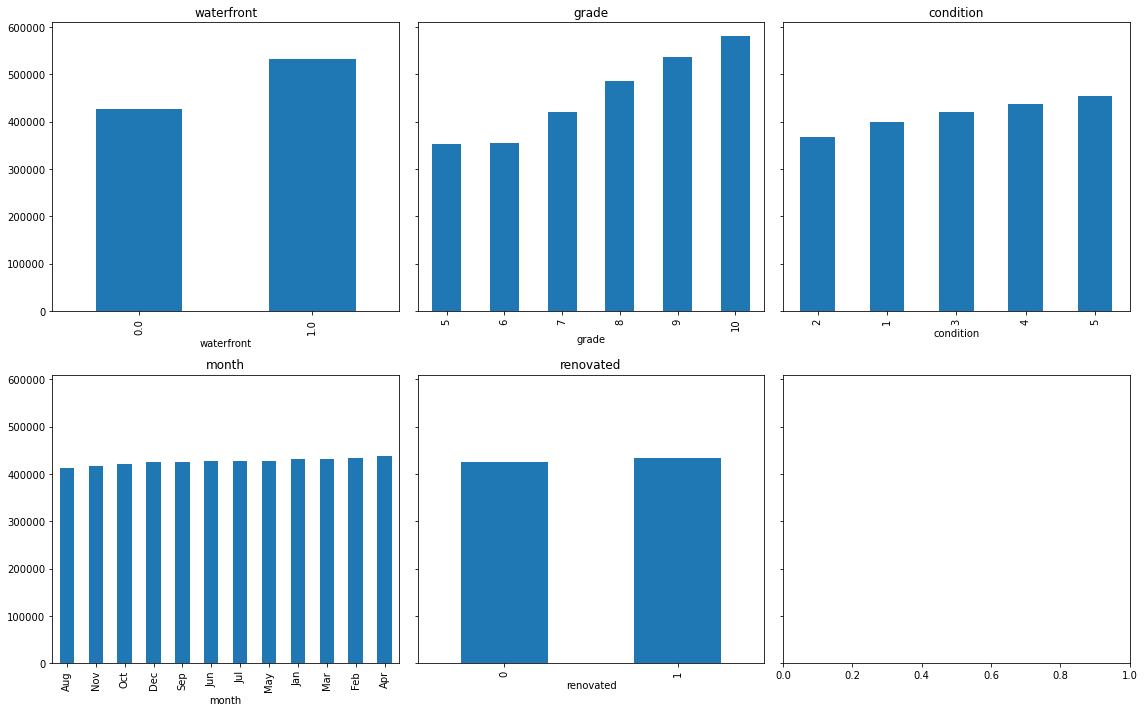

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16,10), sharey=True)

categorical = ['waterfront', 'grade', 'condition', 'month', 'renovated']

for col, ax in zip(categorical, axes.flatten()):
    (df_seattle_no_outliers.groupby(col)               # group values together by column of interest
         .mean()['price']        # take the mean of the saleprice for each group
         .sort_values()              # sort the groups in ascending order
         .plot
         .bar(ax=ax))                # create a bar graph on the ax
    
    ax.set_title(col)                # Make the title the name of the column
    
fig.tight_layout()

`grade` and `condition` seem to be categorical variables worth exploring. However, what do these categorical values represent?

https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r

BUILDING CONDITION
    	Relative to age and grade. Coded 1-5.

1 = Poor- Worn out. Repair and overhaul needed on painted surfaces, roofing, plumbing, heating and numerous functional inadequacies. Excessive deferred maintenance and abuse, limited value-in-use, approaching abandonment or major reconstruction; reuse or change in occupancy is imminent. Effective age is near the end of the scale regardless of the actual chronological age.

2 = Fair- Badly worn. Much repair needed. Many items need refinishing or overhauling, deferred maintenance obvious, inadequate building utility and systems all shortening the life expectancy and increasing the effective age.

3 = Average- Some evidence of deferred maintenance and normal obsolescence with age in that a few minor repairs are needed, along with some refinishing. All major components still functional and contributing toward an extended life expectancy. Effective age and utility is standard for like properties of its class and usage.

4 = Good- No obvious maintenance required but neither is everything new. Appearance and utility are above the standard and the overall effective age will be lower than the typical property.

5= Very Good- All items well maintained, many having been overhauled and repaired as they have shown signs of wear, increasing the life expectancy and lowering the effective age with little deterioration or obsolescence evident with a high degree of utility.
____
BUILDING GRADE
    	Represents the construction quality of improvements. Grades run from grade 1 to 13. Generally defined as:

1-3 Falls short of minimum building standards. Normally cabin or inferior structure.

4 Generally older, low quality construction. Does not meet code.

5 Low construction costs and workmanship. Small, simple design.

6 Lowest grade currently meeting building code. Low quality materials and simple designs.

7 Average grade of construction and design. Commonly seen in plats and older sub-divisions.

8 Just above average in construction and design. Usually better materials in both the exterior and interior finish work.

9 Better architectural design with extra interior and exterior design and quality.

10 Homes of this quality generally have high quality features. Finish work is better and more design quality is seen in the floor plans. Generally have a larger square footage.

11 Custom design and higher quality finish work with added amenities of solid woods, bathroom fixtures and more luxurious options.

12 Custom design and excellent builders. All materials are of the highest quality and all conveniences are present.

13 Generally custom designed and built. Mansion level. Large amount of highest quality cabinet work, wood trim, marble, entry ways etc.

OK. Good to know. Now let's update our dataframe to include dummies for `grade` and `condition` and run a regression with these alongside `sqft_living`.

In [28]:
#Dummy grade
grade_origin = df_seattle_no_outliers['grade']

#Avoid dummy variable trap
df_grade_dummy = pd.get_dummies(grade_origin, drop_first=True)

df_seattle_no_outliers = pd.concat([df_grade_dummy, df_seattle_no_outliers], axis=1)

#Rename columns for clarity
mapper = {6:'Grade 6',7:'Grade 7',8:'Grade 8',9:'Grade 9',10:'Grade 10'}
df_seattle_no_outliers.rename(mapper=mapper, axis=1, inplace=True)

#Dummy condition
condition_origin = df_seattle_no_outliers['condition']

#Avoid dummy variable trap
df_condition_dummy = pd.get_dummies(condition_origin, drop_first=True)

df_seattle_no_outliers = pd.concat([df_condition_dummy, df_seattle_no_outliers], axis=1)

#Rename columns for clarity
mapper = {1:'Condition 1',2:'Condition 2',3:'Condition 3',4:'Condition 4',5:'Condition 5'}
df_seattle_no_outliers.rename(mapper=mapper, axis=1, inplace=True)

df_seattle_no_outliers

,Condition 2,Condition 3,Condition 4,Condition 5,Grade 6,Grade 7,Grade 8,Grade 9,Grade 10,price,...,zipcode,lat,long,sqft_living15,sqft_lot15,month,renovated,age_of_house,City,price_adjusted_M
1,0,1,0,0,0,1,0,0,0,538000.0,...,98125,47.7210,-122.319,1690,7639,Dec,1,70,Seattle,0.538000
3,0,0,0,1,0,1,0,0,0,604000.0,...,98136,47.5208,-122.393,1360,5000,Dec,0,56,Seattle,0.604000
7,0,1,0,0,0,1,0,0,0,291850.0,...,98198,47.4095,-122.315,1650,9711,Jan,0,58,Seattle,0.291850
11,0,0,1,0,0,1,0,0,0,468000.0,...,98115,47.6900,-122.292,1330,6000,May,0,79,Seattle,0.468000
15,0,1,0,0,0,0,0,1,0,650000.0,...,98126,47.5714,-122.375,2140,4000,Jan,0,42,Seattle,0.650000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21575,0,1,0,0,0,0,1,0,0,572000.0,...,98178,47.5001,-122.232,1810,5641,Oct,1,7,Seattle,0.572000
21591,0,1,0,0,0,0,1,0,0,475000.0,...,98116,47.5773,-122.409,1330,1265,Feb,0,13,Seattle,0.475000
21593,0,1,0,0,0,0,1,0,0,400000.0,...,98146,47.5107,-122.362,1830,7200,Feb,0,7,Seattle,0.400000
21594,0,1,0,0,0,1,0,0,0,402101.0,...,98144,47.5944,-122.299,1020,2007,Jun,0,12,Seattle,0.402101


In [29]:
#For regression
x_variables = ['Grade 6','Grade 7','Grade 8','Grade 9','Grade 10', 
                                   'Condition 2', 'Condition 3', 'Condition 4', 'Condition 5', 'sqft_living']

df_x = df_seattle_no_outliers[x_variables]
df_y = df_seattle_no_outliers['price_adjusted_M']

model = sm.OLS(df_y, df_x).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:       price_adjusted_M   R-squared (uncentered):                   0.948
Model:                            OLS   Adj. R-squared (uncentered):              0.948
Method:                 Least Squares   F-statistic:                              8415.
Date:                Thu, 22 Apr 2021   Prob (F-statistic):                        0.00
Time:                        09:51:41   Log-Likelihood:                          4050.5
No. Observations:                4601   AIC:                                     -8081.
Df Residuals:                    4591   BIC:                                     -8017.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Grade 6         0.0248      0.019      1.277      0.202      -0.013       0.063
Grade 7         0.0734      0.019      3.802      0.000       0.036       0.111
Grade 8         0.1343      0.020      6.849      0.000       0.096       0.173
Grade 9         0.1829      0.022      8.452      0.000       0.140       0.225
Grade 10        0.2386      0.037      6.414      0.000       0.166       0.312
Condition 2     0.2592      0.025     10.465      0.000       0.211       0.308
Condition 3     0.2646      0.019     13.722      0.000       0.227       0.302
Condition 4     0.2981      0.019     15.289      0.000       0.260       0.336
Condition 5     0.3137      0.020     15.730      0.000       0.275       0.353
sqft_living  4.251e-05   3.22e-06     13.207      0.000    3.62e-05    4.88e-05
==============================================================================
Omnibus:                      108.875   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              110.782
Skew:                           0.358   Prob(JB):                     8.79e-25
Kurtosis:                       2.747   Cond. No.                     6.58e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 6.58e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Nice!  Our r-squared value has shot up to .947, meaning that 94.7% of the variability in price can be explained by `grade` and `condition`

How do our assumptions for linear regression look?

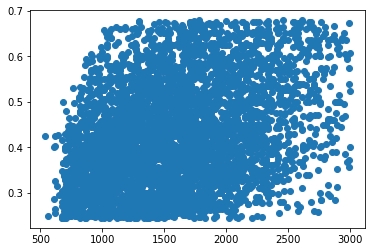

In [30]:
#1. The relationship between the target and predictor is linear. True - sqft_living vs price seems generally linear
plt.scatter(df_seattle_no_outliers['sqft_living'], df_seattle_no_outliers['price_adjusted_M'])

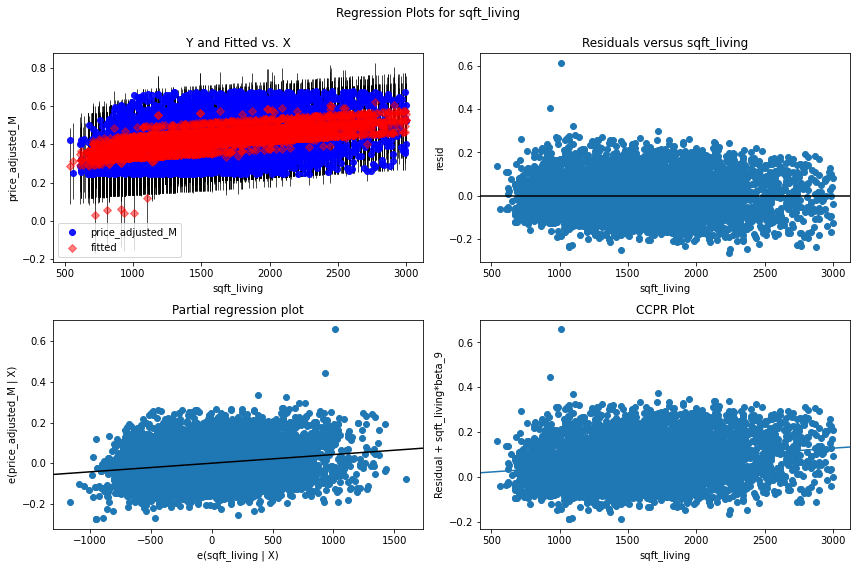

In [31]:
#2. The errors are independent. True - no apparent patterns in the residuals versus sqft_living plot?

sm.graphics.plot_regress_exog(model, 'sqft_living', fig=plt.figure(figsize=(12, 8)));

<ipython-input-32-54d5f5de292b>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


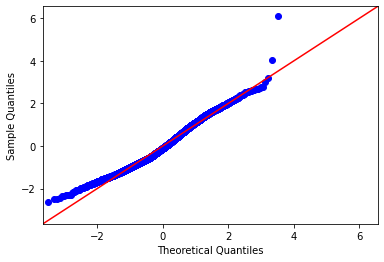

In [32]:
#3. The errors are normally distributed. mostly True, some deviations at ends of our data.

residuals = model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

In [33]:
#4. The errors are homoskedastic (errors have the same variance) - True, GFQ test and residual plot seems patternless.

sms.het_goldfeldquandt(model.resid, model.model.exog)

#The larger the F-statistic, the more evidence we will have against the homoscedasticity assumption 
#and the more likely we have heteroscedasticity (different variance for the two groups).



(1.0319501825133306, 0.22587489279561562, 'increasing')

#### Additional thoughts

Is there a statistical difference in price between grade? Between condition?

In [84]:
df_seattle_no_outliers['grade'].value_counts().sort_index()

5       28
6      713
7     2737
8     1000
9      113
10      10
Name: grade, dtype: int64

>Above: Because n < 30 for grade = 10, we will exclude this group in our statistical tests.
***
>Below: Because n < 30 for condition = 1, we will exclude this group in our statistical tests.


In [72]:
df_seattle_no_outliers['condition'].value_counts().sort_values()

1       6
2      33
5     415
4    1142
3    3005
Name: condition, dtype: int64

#### Grade Statistical Testing

In [60]:
#Isolating price based on grade
grade5_prices = df_seattle_no_outliers[df_seattle_no_outliers['grade'] == 5]['price']
grade6_prices = df_seattle_no_outliers[df_seattle_no_outliers['grade'] == 6]['price']
grade7_prices = df_seattle_no_outliers[df_seattle_no_outliers['grade'] == 7]['price']
grade8_prices = df_seattle_no_outliers[df_seattle_no_outliers['grade'] == 8]['price']
grade9_prices = df_seattle_no_outliers[df_seattle_no_outliers['grade'] == 9]['price']
grade10_prices = df_seattle_no_outliers[df_seattle_no_outliers['grade'] == 10]['price']

lst = [grade5_prices, grade6_prices, grade7_prices, grade8_prices, grade9_prices, grade10_prices]

x = 5

#Showing average price for each grade
for element in lst:
    print('Grade', x, 'average price:', element.mean().round(2))
    x += 1

Grade 5 average price: 353335.71
Grade 6 average price: 354443.95
Grade 7 average price: 419454.19
Grade 8 average price: 485296.76
Grade 9 average price: 537320.62
Grade 10 average price: 580795.0


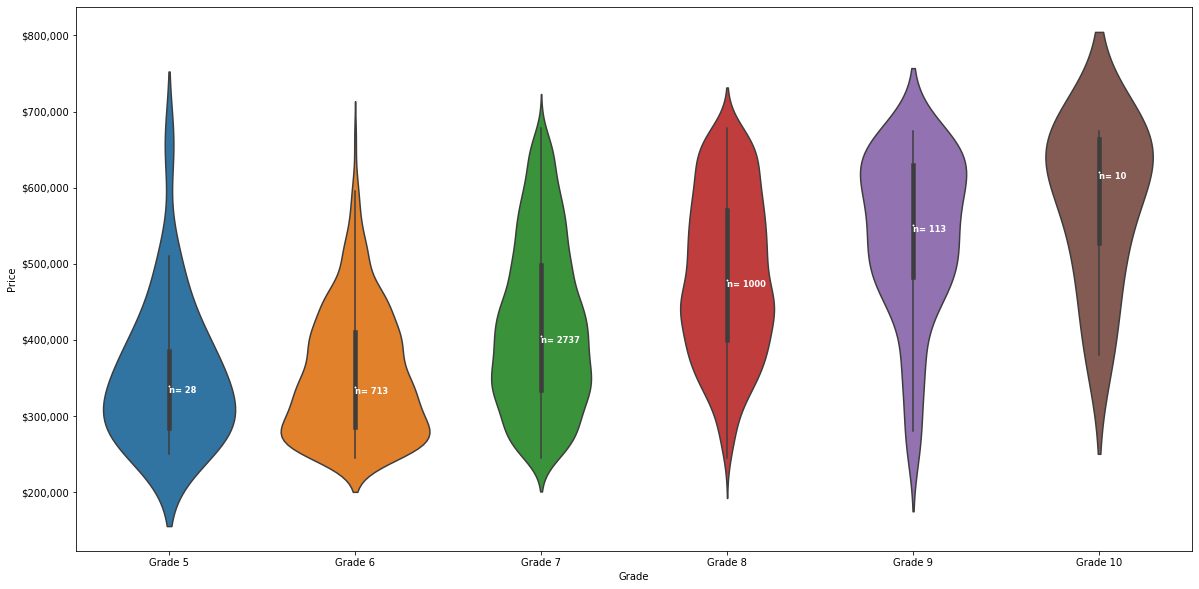

In [101]:
import matplotlib.ticker as tkr

lst = [grade5_prices, grade6_prices, grade7_prices, grade8_prices, grade9_prices, grade10_prices]

xticks_t =  ["Grade 5", "Grade 6", "Grade 7", "Grade 8", "Grade 9", "Grade 10"]
ordering = df_seattle_no_outliers['grade'].value_counts().sort_index().index
n_obs_count = [grade5_prices.count(), grade6_prices.count(), grade7_prices.count(), 
               grade8_prices.count(), grade9_prices.count(), grade10_prices.count()]

fig, ax = plt.subplots(figsize=(20,10))
sns.violinplot(x='grade', y='price', data=df_seattle_no_outliers, split=True, order=ordering).set_xticklabels(xticks_t)
fmt = '${x:,.0f}'
tick = tkr.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
ax.set(ylabel='Price', xlabel='Grade')

medians = df_seattle_no_outliers.groupby(['grade'])['price'].median().values
n_obs = df_seattle_no_outliers['grade'].value_counts().sort_index().values
n_obs = [str(x) for x in n_obs.tolist()]
n_obs = ['n= ' + i for i in n_obs]
pos = range(len(n_obs))
for tick, label in zip(pos, ax.get_xticklabels()):
    ax.text(pos[tick], medians[tick], n_obs[tick], verticalalignment='top', size='small', color='w', weight='semibold')

plt.show()

Reject tests involving Grades 5 and 10, because n < 30.

In [45]:
#null = there is no difference in price between grades 6 and 7
#alternative = there is a difference in price between grades 6 and 7

stats.ttest_ind(grade6_prices, grade7_prices)

#reject null. There is a statistically significant difference in price between grades 6 and 7.

Ttest_indResult(statistic=-15.030770842570194, pvalue=1.653237299945723e-49)

In [46]:
#null = there is no difference in price between grades 7 and 8
#alternative = there is a difference in price between grades 7 and 8

stats.ttest_ind(grade8_prices, grade7_prices)

#reject null. There is a statistically significant difference in price between grades 7 and 8.

Ttest_indResult(statistic=16.693494927755932, pvalue=2.1455455141377468e-60)

In [47]:
#null = there is no difference in price between grades 8 and 9
#alternative = there is a difference in price between grades 8 and 9

stats.ttest_ind(grade8_prices, grade9_prices)

#reject null. There is a statistically significant difference in price between grades 8 and 9.

Ttest_indResult(statistic=-4.9952277335272495, pvalue=6.82068778132271e-07)

### Summary of Statistical Tests for `grade`

In [63]:
#Difference in price between 6 to 7 | 7 to 8 | 8 to 9

#T-test for confidence interval. 

x  = 5

for element in lst:
    interval_start, interval_end = stats.t.interval(alpha=.05, df=element.count(), 
                                                loc=element.mean(), scale=element.std())
    confidence_interval = [interval_start.round(2), interval_end.round(2)]
    print('Grade', x, 'confidence interval:', confidence_interval)
    
    x+=1

Grade 5 confidence interval: [347506.36, 359165.07]
Grade 6 confidence interval: [349233.25, 359654.64]
Grade 7 confidence interval: [412717.48, 426190.9]
Grade 8 confidence interval: [478719.86, 491873.66]
Grade 9 confidence interval: [530679.54, 543961.7]
Grade 10 confidence interval: [574187.35, 587402.65]


#### Condition Statistical Testing

In [66]:
#Isolating price based on condition
condition1_prices = df_seattle_no_outliers[df_seattle_no_outliers['condition'] == 1]['price']
condition2_prices = df_seattle_no_outliers[df_seattle_no_outliers['condition'] == 2]['price']
condition3_prices = df_seattle_no_outliers[df_seattle_no_outliers['condition'] == 3]['price']
condition4_prices = df_seattle_no_outliers[df_seattle_no_outliers['condition'] == 4]['price']
condition5_prices = df_seattle_no_outliers[df_seattle_no_outliers['condition'] == 5]['price']

lst = [condition1_prices, condition2_prices, condition3_prices, condition4_prices, condition5_prices]

x = 1

#Showing average price for each grade
for element in lst:
    print('Condition', x, 'average price:', element.mean().round(2))
    x += 1

Condition 1 average price: 399833.33
Condition 2 average price: 366568.42
Condition 3 average price: 419634.43
Condition 4 average price: 436724.51
Condition 5 average price: 453598.53


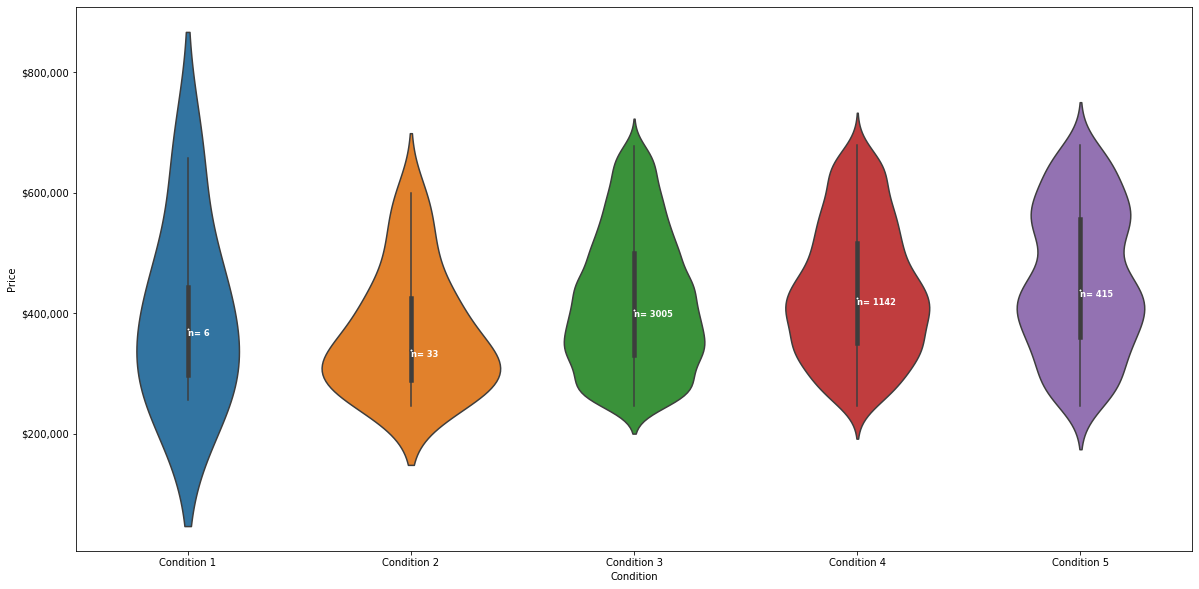

In [102]:
import matplotlib.ticker as tkr

lst = [condition1_prices, condition2_prices, condition3_prices, condition4_prices, condition5_prices]

xticks_t =  ["Condition 1", "Condition 2", "Condition 3", "Condition 4", "Condition 5"]
ordering = df_seattle_no_outliers['condition'].value_counts().sort_index().index
n_obs_count = [condition1_prices.count(), condition2_prices.count(), condition3_prices.count(), 
               condition4_prices.count(), condition5_prices.count()]

fig, ax = plt.subplots(figsize=(20,10))
sns.violinplot(x='condition', y='price', data=df_seattle_no_outliers, split=True, order=ordering).set_xticklabels(xticks_t)
fmt = '${x:,.0f}'
tick = tkr.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
ax.set(ylabel='Price', xlabel='Condition')

medians = df_seattle_no_outliers.groupby(['condition'])['price'].median().values
n_obs = df_seattle_no_outliers['condition'].value_counts().sort_index().values
n_obs = [str(x) for x in n_obs.tolist()]
n_obs = ['n= ' + i for i in n_obs]
pos = range(len(n_obs))
for tick, label in zip(pos, ax.get_xticklabels()):
    ax.text(pos[tick], medians[tick], n_obs[tick], verticalalignment='top', size='small', color='w', weight='semibold')

plt.show()

In [49]:
#Isolating price based on condition
condition2_prices = df_seattle_no_outliers[df_seattle_no_outliers['condition'] == 2]['price']
condition3_prices = df_seattle_no_outliers[df_seattle_no_outliers['condition'] == 3]['price']
condition4_prices = df_seattle_no_outliers[df_seattle_no_outliers['condition'] == 4]['price']
condition5_prices = df_seattle_no_outliers[df_seattle_no_outliers['condition'] == 5]['price']

con_list = [condition2_prices, condition3_prices, condition4_prices, condition5_prices]

w = 2

#Showing average price for each grade
for element in con_list:
    print('Condition', w, 'average price:', element.mean().round(2))
    w += 1

Condition 2 average price: 366568.42
Condition 3 average price: 419634.43
Condition 4 average price: 436724.51
Condition 5 average price: 453598.53


In [50]:
#null = there is no difference in price between conditions 2 and 3
#alternative = there is a difference in price between grades 2 and 3

stats.ttest_ind(condition2_prices, condition3_prices)

#reject null. There is a difference in price between grades 2 and 3

Ttest_indResult(statistic=-2.714360097844114, pvalue=0.006677936605240378)

In [51]:
#null = there is no difference in price between conditions 2 and 4
#alternative = there is a difference in price between grades 2 and 4

stats.ttest_ind(condition2_prices, condition4_prices)

#reject null. There is a difference in price between grades 2 and 4

Ttest_indResult(statistic=-3.6457572150573894, pvalue=0.00027828446362702626)

In [52]:
#null = there is no difference in price between conditions 2 and 5
#alternative = there is a difference in price between grades 2 and 5

stats.ttest_ind(condition2_prices, condition5_prices)

#reject null. There is a difference in price between grades 2 and 5

Ttest_indResult(statistic=-4.102688118421145, pvalue=4.855406313581998e-05)

In [53]:
#null = there is no difference in price between conditions 3 and 4
#alternative = there is a difference in price between grades 3 and 4

stats.ttest_ind(condition3_prices, condition4_prices)

#reject null. There is a difference in price between grades 3 and 4

Ttest_indResult(statistic=-4.424325434832916, pvalue=9.922799213467629e-06)

In [54]:
#null = there is no difference in price between conditions 3 and 5
#alternative = there is a difference in price between grades 3 and 5

stats.ttest_ind(condition3_prices, condition5_prices)

#reject null. There is a difference in price between grades 3 and 5

Ttest_indResult(statistic=-5.756773230594497, pvalue=9.330423611918878e-09)

In [55]:
#null = there is no difference in price between conditions 4 and 5
#alternative = there is a difference in price between grades 4 and 5

stats.ttest_ind(condition4_prices, condition5_prices)

#reject null. There is a difference in price between grades 4 and 5

Ttest_indResult(statistic=-2.6331209671027667, pvalue=0.00854425849716241)

### Summary of Statistical Tests for `condition`

In [56]:
#There is a difference in price between all groups of prices based on condition 
#(from 2 - 5, 1 was dropped because the sample size is far too small for reliability)

#T-test for confidence interval. 

g  = 2

for element in con_list:
    interval_start_con, interval_end_con = stats.t.interval(alpha=.05, df=element.count(), 
                                                loc=element.mean(), scale=element.std())
    confidence_interval_con = [interval_start_con.round(2), interval_end_con.round(2)]
    print('Condition', g, 'confidence interval:', confidence_interval_con)
    
    g += 1

Condition 2 confidence interval: [360306.79, 372830.06]
Condition 3 confidence interval: [412621.86, 426646.99]
Condition 4 confidence interval: [429872.62, 443576.4]
Condition 5 confidence interval: [446158.59, 461038.47]


### Check of correlation between `grade` and `condition`:

In [57]:
df_seattle_no_outliers[['grade', 'condition']].corr()

,grade,condition
grade,1.000000,-0.150922
condition,-0.150922,1.000000


# Conclusion

Our analysis shows that `sqft_living` is strongly correlated with the price of a house. While we realize that increasing an already-built house's footage may not always be realistic, we've discovered that there is statistical differences in the price of homes depending on it's Grade or Condition rating.

For Grade, we're 95% confident of the following: <br>
- Upgrading homes with a grade of 6 to a 7 can generate a 53K - 77K property value increase.
- Upgrading homes with a grade of 7 to an 8 can generate a 105K - 131K property value increase.
- Upgrading homes with a grade of 8 to a 9 can generate a 30 - 56 property value increase.

For Condition, we're 95% confident of the following: <br>
- Upgrading homes with a condition of 2 to a 3 can generate a 40K - 67K property value increase.
- Upgrading homes with a condition of 2 to a 4 can generate a 57K - 84K property value increase.
- Upgrading homes with a condition of 2 to a 5 can generate a 73K - 101K property value increase.
- Upgrading homes with a condition of 3 to a 4 can generate a 3K - 31K property value increase.
- Upgrading homes with a condition of 3 to a 5 can generate a 19K - 48K property value increase.
- Upgrading homes with a condition of 4 to a 5 can generate a 2K - 31K property value increase.